## Описание проекта

Data Science в каршеринговой компании. 
<br><br>
Нам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.<br>
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.<br><br>
Идея решения задачи от заказчика:
<br>
Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
<br>
Для модели выбрать тип виновника — только машина (car).
<br>
Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
<br>
Для моделирования ограничиться данными за 2012 год — они самые свежие.
<br>
Обязательное условие — учесть фактор возраста автомобиля.
<br>
На основе модели исследовать основные факторы ДТП.
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
Какие ещё факторы нужно учесть?
Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?


## Подключение к базе. Загрузка таблицы sql

In [1]:
# Установим необходимые библиотеки
!pip install sqlalchemy 
!pip install scikit-learn==1.1.3 -q
!pip -q install phik
!pip install category_encoders
!pip install shap

In [2]:
# Импортируем остальные библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix, precision_recall_curve, precision_score
from sklearn.compose import ColumnTransformer
import time
from scipy.stats import uniform, randint
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
import shap
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=FitFailedWarning)

# снимим ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

In [3]:
# Запишим в объект данные для подключения к базе данных Практикума
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

In [4]:
# Сформируем строку для подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [5]:
# Создадим подклдючение к БД
engine = create_engine(connection_string) 

In [6]:
# Выведем имена таблиц БД
query = '''
SELECT table_name 
FROM information_schema.tables
'''   
tables = pd.read_sql_query(query, con=engine)   
tables

,table_name
0,pg_type
1,pg_foreign_table
2,pg_roles
3,pg_settings
4,pg_amop
...,...
183,pg_inherits
184,collisions
185,case_ids
186,parties


189 таблиц в БД, интересующие нас collisions, parties и vehicles в конце списка.

Осуществлено подключение к базе данных. Проверено наличие необходимых нам таблиц среди имеющихся в БД. В работе нам понадобятся таблицы collisions, parties и vehicles.

## Проведите первичное исследование таблиц

Выгрузим первые пять строк таблиц для ознакомления содержания. Посмотрим тип данных в таблицах для формирования корректных запросов в дальнейшем.

In [7]:
query = '''
SELECT *
FROM collisions
LIMIT 5;
'''
collisions = pd.read_sql_query(query, con=engine) 
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [8]:
query = '''
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'collisions';
'''
pd.read_sql_query(query, con=engine, index_col='column_name')

,data_type
column_name,
party_count,integer
intersection,integer
distance,real
collision_date,date
collision_time,time without time zone
location_type,text
collision_damage,text
case_id,text
pcf_violation_category,text


In [9]:
query = '''
SELECT *
FROM parties
LIMIT 5;
'''
parties = pd.read_sql_query(query, con=engine) 
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [10]:
query = '''
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'parties';
'''
pd.read_sql_query(query, con=engine, index_col='column_name')

,data_type
column_name,
cellphone_in_use,integer
party_number,integer
at_fault,integer
insurance_premium,integer
id,integer
case_id,text
party_drug_physical,text
party_type,text
party_sobriety,text


In [11]:
query = '''
SELECT *
FROM vehicles
LIMIT 5;
'''
vehicles = pd.read_sql_query(query, con=engine) 
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [12]:
query = '''
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'vehicles';
'''
pd.read_sql_query(query, con=engine, index_col='column_name')

,data_type
column_name,
id,integer
party_number,integer
vehicle_age,integer
case_id,text
vehicle_type,text
vehicle_transmission,text


##  Проведите статистический анализ факторов ДТП

### Анализ данных с применением SQL-запросов

In [13]:
# Выясним, в какие месяцы происходит наибольшее количество аварий.
query = '''
SELECT DATE_TRUNC('month', collision_date) AS month,
       COUNT(case_id) AS collisions_cnt
FROM collisions
GROUP BY month;
'''

collision_cnt_month = pd.read_sql_query(query, con=engine, index_col='month') 
collision_cnt_month

,collisions_cnt
month,
2009-01-01 00:00:00+03:00,35062
2009-02-01 00:00:00+03:00,34480
2009-03-01 00:00:00+03:00,36648
2009-04-01 00:00:00+04:00,35239
2009-05-01 00:00:00+04:00,36916
2009-06-01 00:00:00+04:00,34202
2009-07-01 00:00:00+04:00,35161
2009-08-01 00:00:00+04:00,34508
2009-09-01 00:00:00+04:00,35555


Данные охватывают период с января 2009 по июль 2020. При этом с 2012 года наблюдается резкое снижение количества зарегистрированных аварий, затем с августа 2013 по февраль 2020 аварии отсутствуют вовсе. Вероятно, с 2012 года база формировалась некорректно. Уберем данный период из запроса и сгрупперуем усредненные данные по количеству аварий по месяцам.

In [14]:
# Выясним, в какие месяцы происходит наибольшее количество аварий в периоде с 2009 по 2011 год включительно.
query = '''
WITH col_per_month AS
    (SELECT DATE_TRUNC('month', collision_date) AS data,
       COUNT(case_id) AS collisions_cnt
    FROM collisions
    WHERE EXTRACT(YEAR FROM collision_date) < 2012
    GROUP BY data)
SELECT EXTRACT(MONTH FROM data)::int AS month,
    AVG(collisions_cnt) AS collisions_cnt_mean
FROM col_per_month
GROUP BY month
'''

collision = pd.read_sql_query(query, con=engine) 
collision.sort_values(by='collisions_cnt_mean', ascending=False)

,month,collisions_cnt_mean
9,10,37311.000000
11,12,35915.000000
2,3,35678.666667
4,5,35049.333333
8,9,34883.000000
10,11,34839.000000
7,8,34489.000000
6,7,33945.000000
3,4,33677.333333
0,1,33293.333333


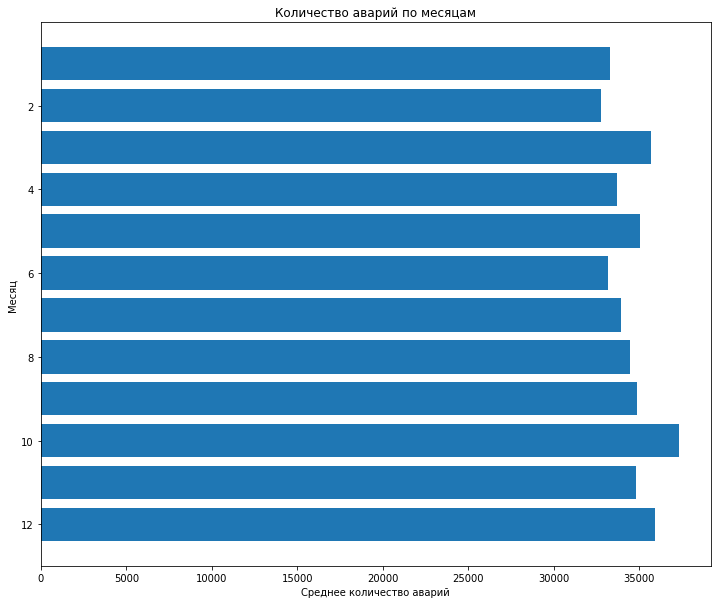

In [15]:
# Выведем на графике результат
plt.figure(figsize=(12, 10))
plt.barh(collision['month'], collision['collisions_cnt_mean'])
plt.gca().invert_yaxis()
plt.title('Количество аварий по месяцам')
plt.xlabel('Среднее количество аварий')
plt.ylabel('Месяц')
plt.show()


Просматривается плавный рост показателя с января по декабрь, с периодическими всплесками в весеннии и осеннии периоды. Всплески возможно связаны с погодными явлениями, а плавный рост по месяцам с развитием сервиса каршеринга и увеличением количества поездок.

Скоро состоится первое совещание нашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого мы должны создать подходящие аналитические задачи и поручить их решение коллегам. 
<br>
Обозначим задачи, которые нам необходимо проанализировать к совещанию:
<br>
1. Проанализировать процент аварий по тяжести повреждений автомобилей в разрезе состояния дорожного покрытия;
<br>
2. Проанализировать процент аварий при разной освещенности в разрезе состояния дорожной обстановки;
<br>
3. Проанализировать процент аварий по возрасту автомобилей на различных дорожных участках
<br>
4. Проанализировать связь между количеством аварий и погодой (таблица collisions);
<br>
5. Проанализировать связь между количеством ДТП и состоянием дороги в момент аварии (таблица collisions);
<br>
6. Проанализировать связь между типом кузова и тяжестью повреждения при аварии (связать collisions и vehicle);
<br>
<br>
Для себя мы выбрали первые три задачи, остальные оставим коллегам.

In [16]:
# 1. Проанализировать процент аварий по тяжести повреждений автомобилей в разрезе состояния дорожного покрытия

# Сформируем таблицу с SQL-запроса.
# Выгрузим количество аварий сгруппированные по road_surface, collision_damage
query = '''
WITH a AS
       (SELECT DISTINCT road_surface,
                        COUNT(*) AS cnt_collisions,
                        collision_damage
       
        FROM collisions
        WHERE case_id IN (SELECT case_id
                          FROM parties
                          WHERE party_type = 'car')
        GROUP BY road_surface, 
                 collision_damage
                 ORDER BY road_surface)
SELECT  road_surface,
        collision_damage,
        cnt_collisions,
        SUM(cnt_collisions) OVER (PARTITION BY road_surface) AS all_count
FROM a
                 
'''
df = pd.read_sql_query(query, con=engine) 
# Преобразуем долю в проценты
df['percentage'] = df['cnt_collisions'] / df['all_count'] * 100
# Заполним пропуски
df.fillna('unknown', inplace=True)

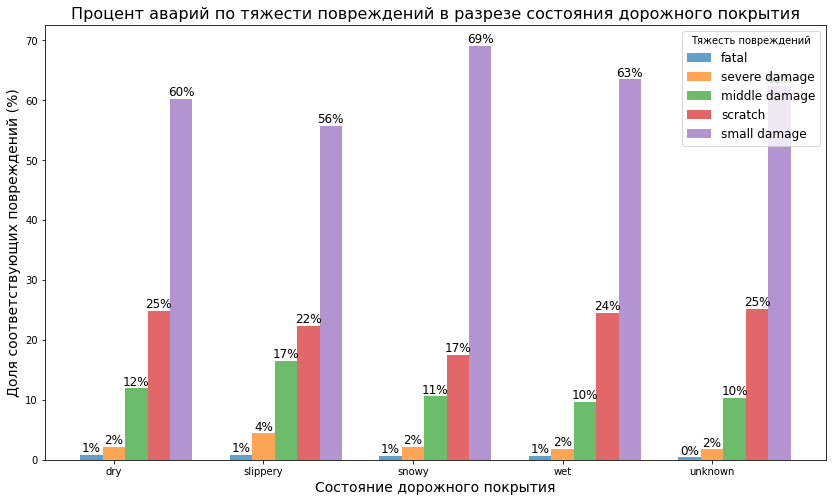

In [17]:
# Выведем график для анализа
plt.figure(figsize=(14, 8))

bar_width = 0.15
index = np.arange(len(df['road_surface'].unique()))


for i, damage_type in enumerate(df['collision_damage'].unique()):
    subset = df[df['collision_damage'] == damage_type]
    plt.bar(
        index + i * bar_width,
        subset['percentage'],  
        width=bar_width,
        label=damage_type,
        alpha=0.7
    )

plt.title('Процент аварий по тяжести повреждений в разрезе состояния дорожного покрытия', fontsize=16)
plt.xlabel('Состояние дорожного покрытия', fontsize=14)
plt.ylabel('Доля соответствующих повреждений (%)', fontsize=14)
plt.xticks(index + bar_width, df['road_surface'].unique(), rotation=0)
plt.legend(title='Тяжесть повреждений', fontsize=12)

for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    text = f'{height:.0f}%'
    plt.annotate(text, 
                 (p.get_x() + width / 2., height),
                 ha='center', va='bottom', fontsize=12)
plt.show()


Сколькое состояние дорожной поверхности приводит к более тяжелым повреждениям автомобилей в результате аварий. Остальные состояния дорожной поверхности не меняют общую пропорцию по тяжести повреждений. Причем, что удивительно, сухое и мокрое состояния имеют идентичные пропорции по тяжести повреждений в результате аварий.

In [18]:
# 2. Проанализировать процент аварий при разной освещенности в разрезе состояния дорожной обстановки

# Сформируем таблицу с SQL-запроса.
# Выгрузим количество аварий сгруппированные по road_condition_1, lighting
query = '''
WITH a AS
   (SELECT DISTINCT road_condition_1,
                COUNT(*) AS cnt_collisions,
                lighting

    FROM collisions
    WHERE case_id IN (SELECT case_id
                  FROM parties
                  WHERE party_type = 'car')
    GROUP BY road_condition_1, 
         lighting
         ORDER BY road_condition_1)
SELECT  road_condition_1,
    lighting,
    cnt_collisions,
    SUM(cnt_collisions) OVER (PARTITION BY road_condition_1) AS all_count
FROM a
                 
'''
df = pd.read_sql_query(query, con=engine) 
# Преобразуем долю в проценты
df['percentage'] = df['cnt_collisions'] / df['all_count'] * 100
# Удалим пропуски
df.dropna(inplace=True)

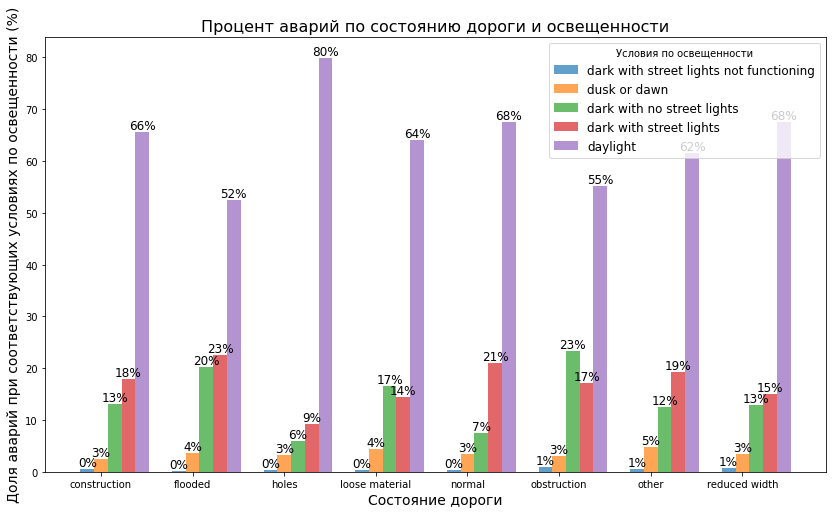

In [19]:
# Выведем график для анализа
plt.figure(figsize=(14, 8))

bar_width = 0.15
index = np.arange(len(df['road_condition_1'].unique()))


for i, lighting_type in enumerate(df['lighting'].unique()):
    subset = df[df['lighting'] == lighting_type]
    plt.bar(
        index + i * bar_width,
        subset['percentage'],  
        width=bar_width,
        label=lighting_type,
        alpha=0.7
    )

plt.title('Процент аварий по состоянию дороги и освещенности', fontsize=16)
plt.xlabel('Состояние дороги', fontsize=14)
plt.ylabel('Доля аварий при соответствующих условиях по освещенности (%)', fontsize=14)
plt.xticks(index + bar_width, df['road_condition_1'].unique(), rotation=0)
plt.legend(title='Условия по освещенности', fontsize=12)

for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    text = f'{height:.0f}%'
    plt.annotate(text, 
                 (p.get_x() + width / 2., height),
                 ha='center', va='bottom', fontsize=12)
plt.show()


Судя по графику, в аварии из-за наличия ям на дороге чаще попадают в светлое время суток. Вероятно, в свете фар в темной время суток ямы более различимы, чем днем. В темное время суток существенно влияет наличие уличного освещения, при каких-то осложнениях или наличия препятсвий оно явно снижает аварийность, но при нормальных условиях или затоплениях - наоборот.

In [20]:
# 3. Проанализировать процент аварий по возрасту автомобилей на различных дорожных участках

# Сформируем таблицу с SQL-запроса.
# Выгрузим количество аварий сгруппированные по location_type, vehicle_age
# vehicle_age категоризируем на newer_car(vehicle_age<5) и older_car(vehicle_age>=5)
query = '''
SELECT 
    c.location_type,
    CASE 
        WHEN v.vehicle_age < 5 THEN 'newer_car'
        ELSE 'older_car'
    END AS car_category,
    COUNT(*) AS cnt_collisions,
    SUM(COUNT(*)) OVER (PARTITION BY c.location_type) AS all_count
FROM collisions c
JOIN vehicles v ON c.case_id = v.case_id
WHERE c.case_id IN (
    SELECT case_id
    FROM parties
    WHERE party_type = 'car'
)
GROUP BY 
    c.location_type,
    CASE 
        WHEN v.vehicle_age < 5 THEN 'newer_car'
        ELSE 'older_car'
    END
ORDER BY 
    c.location_type,
    car_category;
     
'''
df = pd.read_sql_query(query, con=engine) 
# Преобразуем долю в проценты
df['percentage'] = df['cnt_collisions'] / df['all_count'] * 100
# Заполним пропуски
df.fillna('unknown', inplace=True)

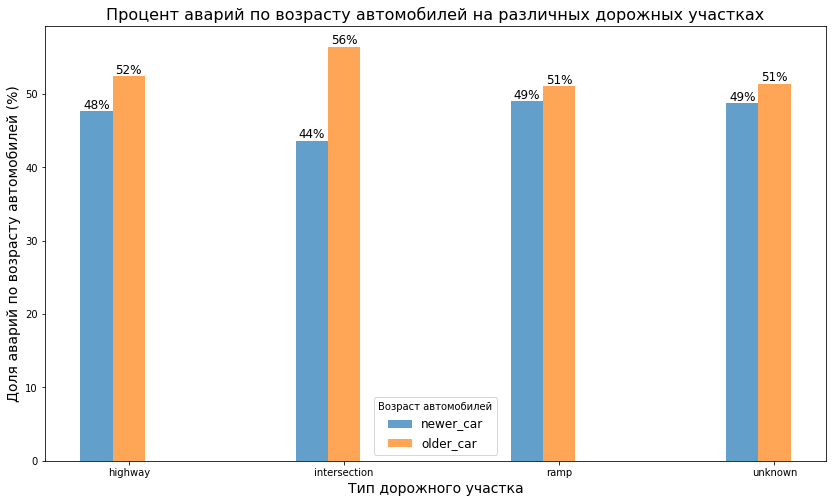

In [21]:
# Выведем график для анализа
plt.figure(figsize=(14, 8))

bar_width = 0.15
index = np.arange(len(df['location_type'].unique()))


for i, vehicle_age_num in enumerate(df['car_category'].unique()):
    subset = df[df['car_category'] == vehicle_age_num]
    plt.bar(
        index + i * bar_width,
        subset['percentage'],  
        width=bar_width,
        label=vehicle_age_num,
        alpha=0.7
    )

plt.title('Процент аварий по возрасту автомобилей на различных дорожных участках', fontsize=16)
plt.xlabel('Тип дорожного участка', fontsize=14)
plt.ylabel('Доля аварий по возрасту автомобилей (%)', fontsize=14)
plt.xticks(index + bar_width, df['location_type'].unique(), rotation=0)
plt.legend(title='Возраст автомобилей', fontsize=12)

for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    text = f'{height:.0f}%'
    plt.annotate(text, 
                 (p.get_x() + width / 2., height),
                 ha='center', va='bottom', fontsize=12)
plt.show()

Мы постарались разделить автомобили по возрасту на относительно новые (до пяти лет) и старые, чтобы попытаться уловить на графиках влияние этого параметра. И обнаружили, что в авариях на перекрестках доля старых автомобилей возрастает на 10% относительно общего распределения. Объяснений этому мы не находим.

In [22]:
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [23]:
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [24]:
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


### Загрузка выборки для модели

Выгрузим из БД данные для модели, отфильтровав их согласно рекомендаций заказчика. Так как перед нам стоит задача предсказания виновности в аварии, мы не будем использовать в модели данные которые формируются самим событием аварии, такие как party_count, pcf_violation_category, motor_vehicle_involved_with, type_of_collision, primary_collision_factor и collision_damage.

In [25]:
# Сформируем SQL-запрос и преобразуем выборку в датафрейм

query = '''
WITH parties_vehicles AS
    (SELECT v.vehicle_type,
            v.vehicle_transmission, 
            v.vehicle_age,
            p.*
    FROM parties AS p
    JOIN vehicles AS v ON p.case_id = v.case_id 
     AND p.party_number = v.party_number
    WHERE p.party_type = 'car')

SELECT c.county_city_location,
       c.distance,
       c.direction,
       c.intersection,
       c.weather_1,
       c.location_type,
       c.road_surface,
       c.road_condition_1,
       c.lighting, 
       c.control_device,
       EXTRACT(MONTH FROM c.collision_date)::int AS collision_month,
       EXTRACT(DOW FROM c.collision_date)::int AS collision_dow,
       EXTRACT(HOUR FROM c.collision_time)::int AS collision_hour,
       v.vehicle_type,
       v.vehicle_transmission, 
       v.vehicle_age,
       v.insurance_premium,
       v.party_sobriety, 
       v.party_drug_physical,
       v.cellphone_in_use,
       v.at_fault
FROM collisions AS c
JOIN parties_vehicles AS v ON c.case_id = v.case_id
WHERE EXTRACT(YEAR FROM c.collision_date) = 2012
  AND c.collision_damage != 'scratch';
'''
df = pd.read_sql_query(query, con=engine)

In [26]:
# Выведем информацию о выборке
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  56248 non-null  object 
 1   distance              56248 non-null  float64
 2   direction             43230 non-null  object 
 3   intersection          56073 non-null  float64
 4   weather_1             56080 non-null  object 
 5   location_type         25932 non-null  object 
 6   road_surface          55900 non-null  object 
 7   road_condition_1      55999 non-null  object 
 8   lighting              56094 non-null  object 
 9   control_device        56033 non-null  object 
 10  collision_month       56248 non-null  int64  
 11  collision_dow         56248 non-null  int64  
 12  collision_hour        56160 non-null  float64
 13  vehicle_type          56248 non-null  object 
 14  vehicle_transmission  55389 non-null  object 
 15  vehicle_age        

In [27]:
# Выведем количестов пропусков в данных
nan_ratio_per_column = (df.isnull().sum() / len(df)) * 100
print(nan_ratio_per_column.sort_values(ascending=False).map("{:.2f}%".format))

party_drug_physical     94.92%
location_type           53.90%
direction               23.14%
cellphone_in_use         7.95%
vehicle_age              3.01%
party_sobriety           1.55%
vehicle_transmission     1.53%
insurance_premium        0.97%
road_surface             0.62%
road_condition_1         0.44%
control_device           0.38%
intersection             0.31%
weather_1                0.30%
lighting                 0.27%
collision_hour           0.16%
county_city_location     0.00%
collision_month          0.00%
vehicle_type             0.00%
collision_dow            0.00%
distance                 0.00%
at_fault                 0.00%
dtype: object


Данные содержат 56248 строк и 21 колонку. В данных значительное количество пропусков. Обработаем их по порядку.

### Заполнение пропусков

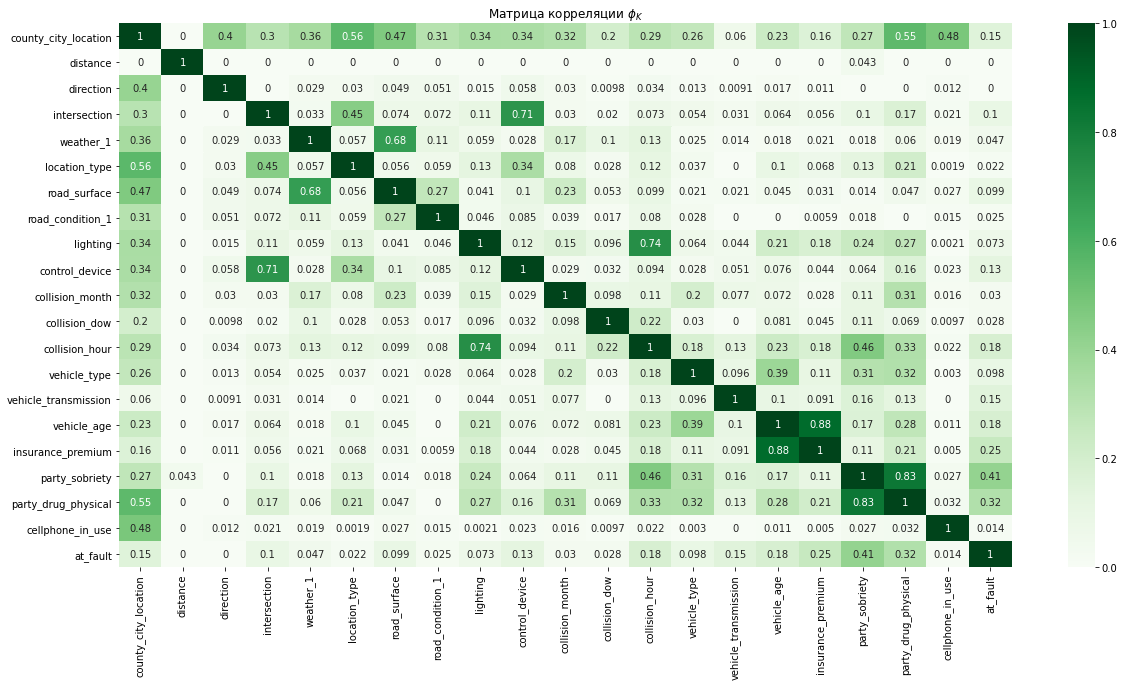

In [28]:
# Обозначим количественные признаки для матрицы
interval_cols = ['distance', 'insurance_premium']

# Выведем матрицу корреляции
target_matrix = df.phik_matrix(interval_cols = interval_cols)
plt.figure(figsize=(20, 10))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

In [29]:
# Начнем с "Состояние участника"
df['party_drug_physical'].unique()

array([None, 'G', 'not applicable', 'impairment - physical',
       'sleepy/fatigued', 'under drug influence'], dtype=object)

In [30]:
# 'G' - это "Не известно". Наверняка анализ состояния не проводился, поэтому заменим их на 'not applicable'.
df['party_drug_physical'] = df['party_drug_physical'].replace('G', 'not applicable')

In [31]:
# Для заполнения пропусков воспользуемся данными матрицы корреляции.
target_matrix['party_drug_physical'].sort_values(ascending=False).head(5)

party_drug_physical     1.000000
party_sobriety          0.828615
county_city_location    0.554586
collision_hour          0.326561
at_fault                0.323913
Name: party_drug_physical, dtype: float64

In [32]:
# Заполним пропуски в 'party_drug_physical' модальным значением для соответсвующих 'party_sobriety'
df['party_drug_physical'] = df['party_drug_physical'].fillna( \
                          df.dropna(subset=['party_sobriety']).groupby('party_sobriety')['party_drug_physical'] \
                                                 .transform(lambda x: x.value_counts().idxmax()))

In [33]:
# Далее location_type
df['location_type'].unique()

array([None, 'ramp', 'highway', 'intersection'], dtype=object)

In [34]:
# Заменим пропуски на 'unknown'
df['location_type'].fillna('unknown', inplace=True)

In [35]:
# Далее direction
df['direction'].unique()

array(['north', 'east', 'south', None, 'west'], dtype=object)

In [36]:
# Заменим пропуски на 'unknown'
df['direction'].fillna('unknown', inplace=True)

In [37]:
# Далее cellphone_in_use
print(df['cellphone_in_use'].unique())
df['cellphone_in_use'].value_counts()

[ 0.  1. nan]


0.0    50723
1.0     1054
Name: cellphone_in_use, dtype: int64

In [38]:
# Заменим пропуски на 0, потому что это в 50 раз чаще чем 1
df['cellphone_in_use'].fillna(0, inplace=True)

In [39]:
# Далее direction
df['vehicle_age'].unique()

array([  8.,   6.,   3.,  nan,   4.,   1.,   5.,   0.,   2.,   7.,  11.,
        13.,  12.,   9.,  10.,  14.,  15.,  17.,  16., 161.,  19.])

In [40]:
df['vehicle_age'].isna().sum()

1694

In [41]:
# Для начала удалим выброс на 161-летнее авто
df = df[df['vehicle_age'] != 161]

In [42]:
# Для заполнения пропусков воспользуемся данными матрицы корреляции.
target_matrix['vehicle_age'].sort_values(ascending=False).head(5)

vehicle_age             1.000000
insurance_premium       0.875466
vehicle_type            0.388067
party_drug_physical     0.276675
county_city_location    0.233938
Name: vehicle_age, dtype: float64

In [43]:
# Пропуски заполним по медианным значением по диапазонам insurance_premium
df['vehicle_age'] = df['vehicle_age'].fillna(df.groupby(pd.cut(df['insurance_premium'], bins=19))['vehicle_age'].transform('median'))
df['vehicle_age'].isna().sum()

128

In [44]:
# 128 пропусков осталось, удалим их 
df = df.dropna(subset=['vehicle_age'])

In [45]:
# Далее party_sobriety
df['party_sobriety'].unique()

array(['had not been drinking', 'had been drinking, under influence',
       'had been drinking, not under influence', 'impairment unknown',
       'not applicable', None, 'had been drinking, impairment unknown'],
      dtype=object)

Пропуски заполним 'not applicable' - значит не оценивался.

In [46]:
df['party_sobriety'].fillna('not applicable', inplace=True)

In [47]:
# Далее vehicle_transmission
df['vehicle_transmission'].unique()

array(['auto', 'manual', None], dtype=object)

In [48]:
# Заменим пропуски на 'auto'. Там такие КПП по умолчанию.
df['vehicle_transmission'].fillna('auto', inplace=True)

In [49]:
# Далее party_sobriety
df['insurance_premium'].unique()

array([ 43.,  38.,  22.,  59.,  30.,  26.,  29.,  35.,  33.,  41.,  23.,
        28.,  42.,  36.,  45.,  18.,   9.,  77.,  70.,  31.,  53.,  49.,
        55.,  76.,  50.,  21.,  27.,  64.,  47.,  75.,  46.,  14.,  54.,
        52.,  48.,  56.,  74.,  20.,  34.,  17.,  25.,  40.,  57.,  32.,
        60.,  58.,  39.,  69.,  51.,  19.,  24.,  71.,  81.,  72.,  63.,
        44.,  37.,  83.,  16.,  15.,  68.,  65.,  67.,  88.,  66.,  82.,
        62.,  73.,  91.,  61.,  78.,  87.,  nan,  80.,  79.,  12.,  92.,
        93.,  84.,  85.,  90.,   0.,  89.,  86.,  97.,   8., 100.,  13.,
         7., 101., 105.,   5., 102.,  96.,  95.,  99.,   6.,  94.,   4.,
        11.,  98.,  10.,   2.])

In [50]:
df['insurance_premium'].isna().sum()

419

In [51]:
# Для заполнения пропусков воспользуемся данными матрицы корреляции.
target_matrix['insurance_premium'].sort_values(ascending=False).head(5)

insurance_premium      1.000000
vehicle_age            0.875466
at_fault               0.250526
party_drug_physical    0.207894
collision_hour         0.183327
Name: insurance_premium, dtype: float64

In [52]:
# Пропуски заполним по медианным значением по диапазонам vehicle_age
df['insurance_premium'] = df['insurance_premium'].fillna(df.groupby(pd.cut(df['vehicle_age'], bins=19))['insurance_premium'].transform('median'))
df['insurance_premium'].isna().sum()

0

In [53]:
# Далее road_surface
df['road_surface'].unique()

array(['dry', 'wet', None, 'snowy', 'slippery'], dtype=object)

In [54]:
# Для заполнения пропусков воспользуемся данными матрицы корреляции.
target_matrix['road_surface'].sort_values(ascending=False).head(5)

road_surface            1.000000
weather_1               0.679306
county_city_location    0.467969
road_condition_1        0.267652
collision_month         0.225340
Name: road_surface, dtype: float64

In [55]:
# Заполним пропуски в 'road_surface' модальным значением для соответсвующих 'weather_1'
df['road_surface'] = df['road_surface'].fillna( \
                          df.dropna(subset=['weather_1']).groupby('weather_1')['road_surface'] \
                                                 .transform(lambda x: x.value_counts().idxmax()))

Значительная часть пропуском заполнена. Можно вывести промежуточный итог.

In [56]:
# Выведем количестов пропусков в данных
nan_ratio_per_column = (df.isnull().sum() / len(df)) * 100
print(nan_ratio_per_column.sort_values(ascending=False).map("{:.2f}%".format))

party_drug_physical     0.58%
road_condition_1        0.44%
control_device          0.38%
intersection            0.31%
weather_1               0.30%
lighting                0.27%
collision_hour          0.16%
road_surface            0.11%
county_city_location    0.00%
vehicle_transmission    0.00%
cellphone_in_use        0.00%
party_sobriety          0.00%
insurance_premium       0.00%
vehicle_age             0.00%
collision_month         0.00%
vehicle_type            0.00%
collision_dow           0.00%
distance                0.00%
location_type           0.00%
direction               0.00%
at_fault                0.00%
dtype: object


Количество оставшихся пропусков незначительное. Можно их удалить.

In [57]:
# Удалим строки с пропусками и выведем информацию по выборке.
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54945 entries, 0 to 56247
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  54945 non-null  object 
 1   distance              54945 non-null  float64
 2   direction             54945 non-null  object 
 3   intersection          54945 non-null  float64
 4   weather_1             54945 non-null  object 
 5   location_type         54945 non-null  object 
 6   road_surface          54945 non-null  object 
 7   road_condition_1      54945 non-null  object 
 8   lighting              54945 non-null  object 
 9   control_device        54945 non-null  object 
 10  collision_month       54945 non-null  int64  
 11  collision_dow         54945 non-null  int64  
 12  collision_hour        54945 non-null  float64
 13  vehicle_type          54945 non-null  object 
 14  vehicle_transmission  54945 non-null  object 
 15  vehicle_age        

### Корреляционный анализ

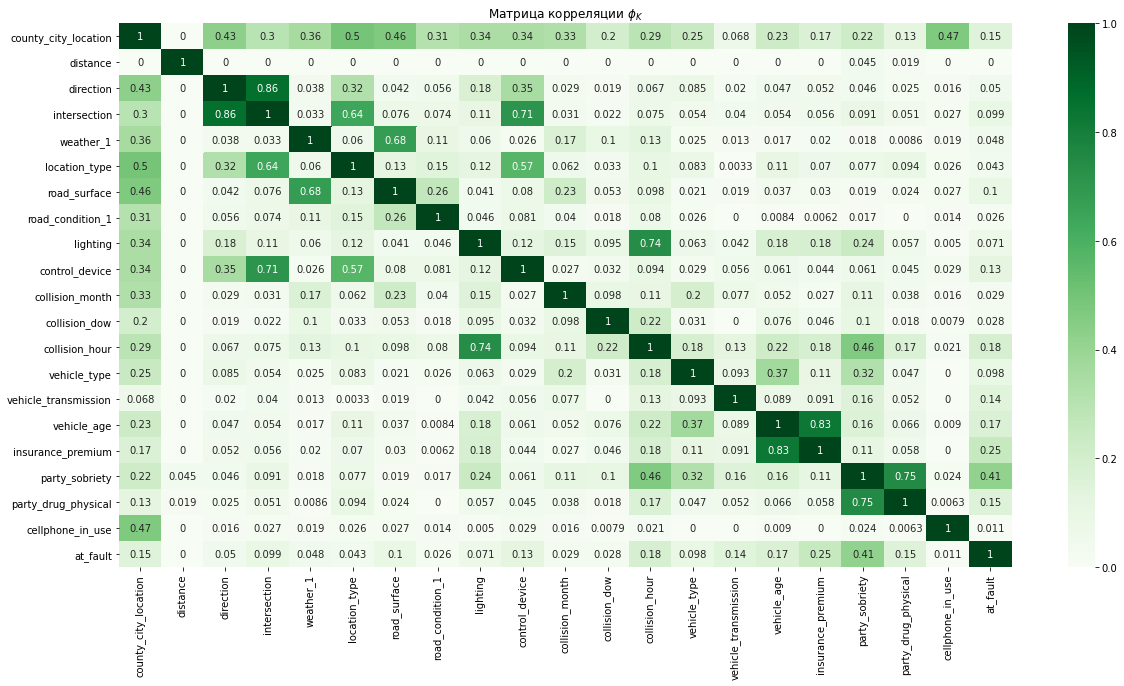

In [58]:
# Обновим матрицу корреляции после заполнения пропусков и удаления лишних признаков
interval_cols = ['distance', 'insurance_premium']

# Выведем матрицу корреляции
target_matrix = df.phik_matrix(interval_cols = interval_cols)
plt.figure(figsize=(20, 10))
sns.heatmap(target_matrix, annot=True, cmap='Greens')
plt.title('Матрица корреляции $\phi_K$')
plt.show()

In [59]:
# Выделим и отсортируем коэффициенты корреляции с нашим целевым признаком
target_matrix['at_fault'].sort_values(ascending=False)

at_fault                1.000000
party_sobriety          0.414518
insurance_premium       0.251096
collision_hour          0.184109
vehicle_age             0.165431
party_drug_physical     0.153429
county_city_location    0.149230
vehicle_transmission    0.144606
control_device          0.125438
road_surface            0.099627
intersection            0.099323
vehicle_type            0.098056
lighting                0.070984
direction               0.049993
weather_1               0.047568
location_type           0.042737
collision_month         0.028695
collision_dow           0.027651
road_condition_1        0.026238
cellphone_in_use        0.011137
distance                0.000000
Name: at_fault, dtype: float64

Судя по матрице корреляции только party_sobriety имеет умеренную связь с целевым признаком с коэффициентами 0.415. У семи связь слабая, у остальных незначительная. Проанализируем часть этих связей на графиках.

In [60]:
# Создадим функцию для вывода графика
def ratio_at_fault (data, x, y):
    plt.figure(figsize=(16, 6))
    data = df.groupby(x)[y].mean().reset_index()
    sns.barplot(x=data[x], y=data[y], saturation=0.5, alpha=0.7)
    plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Уровень 0.5')
    plt.title(f'Вероятность виновности участника в аварии в разрезе {x}', fontsize=14)
    plt.ylabel('Вероятность виновности')
    plt.xticks(rotation=90)
    plt.show()

#### party_sobriety

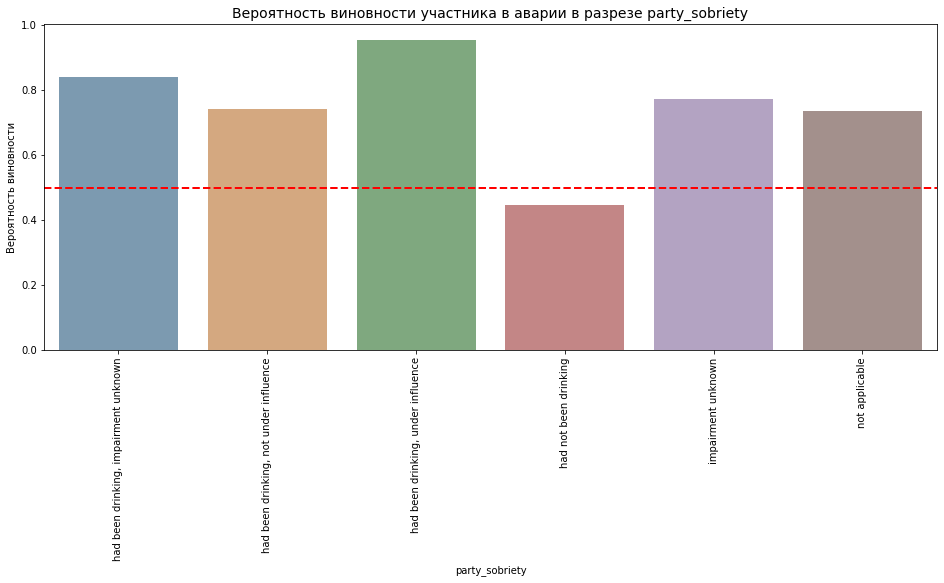

In [61]:
# Выведем график с уровнем трезвости участников аварий
ratio_at_fault(data=df, x='party_sobriety', y='at_fault')

Трезвость снижает вероятность виновности в аварии, в отличии, почему-то, от Not Applicable (Не оценивался).

#### insurance_premium

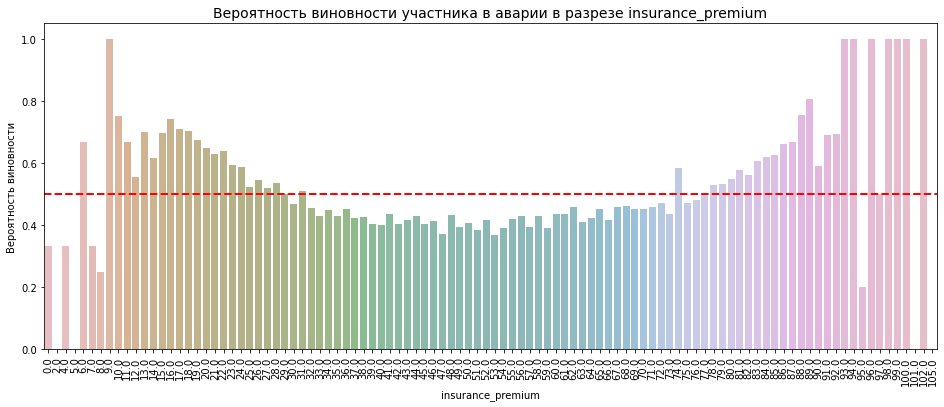

In [62]:
# Выведем график по стоимости страховки
ratio_at_fault(data=df, x='insurance_premium', y='at_fault')

Выше риски по краям распределения стоимости страховки, минимальные риски в среднем диапазоне.

#### Время аварии

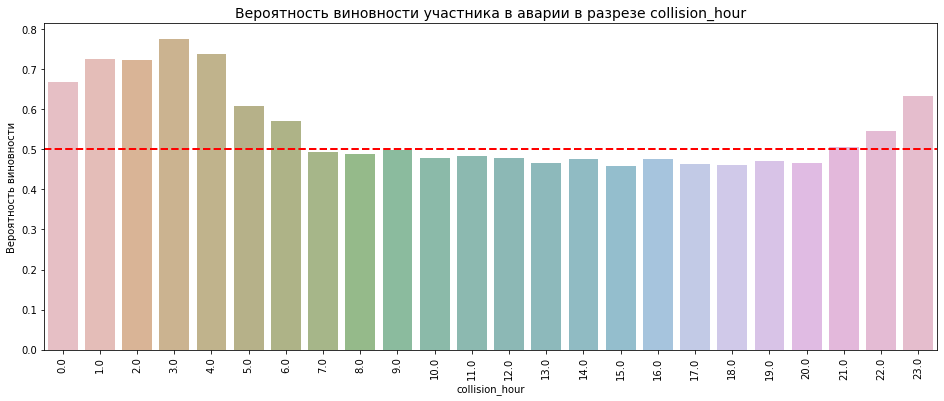

In [63]:
# Выведем график по времени суток
ratio_at_fault(data=df, x='collision_hour', y='at_fault')

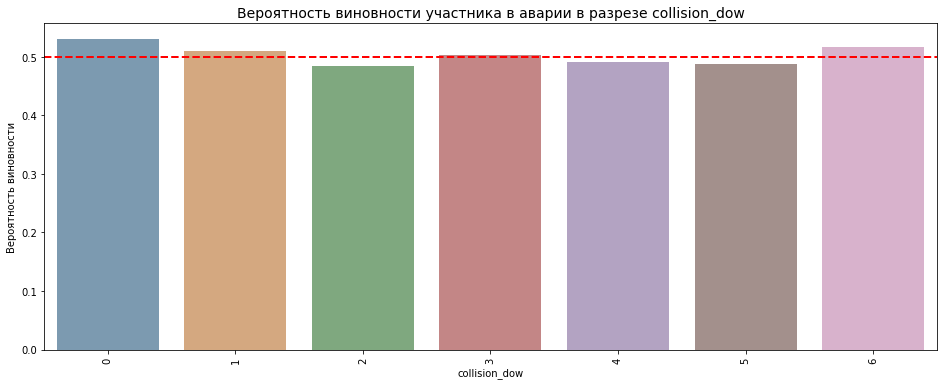

In [64]:
# Выведем график по дням недели
ratio_at_fault(data=df, x='collision_dow', y='at_fault')

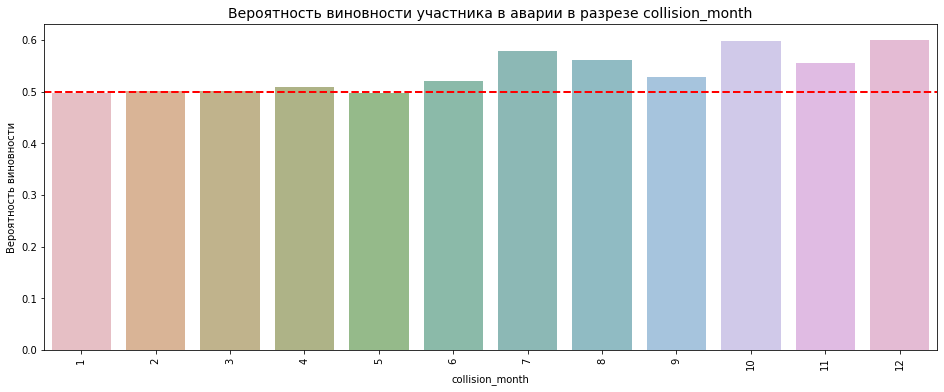

In [65]:
# Выведем график по месяцам
ratio_at_fault(data=df, x='collision_month', y='at_fault')

По времени суток - максимальные риски в темное время с 22-00 до 06-00. По дням недели - выходные. По месяцам - риски виновности растут с июня и до конца года. 

#### Возраст автомобилей

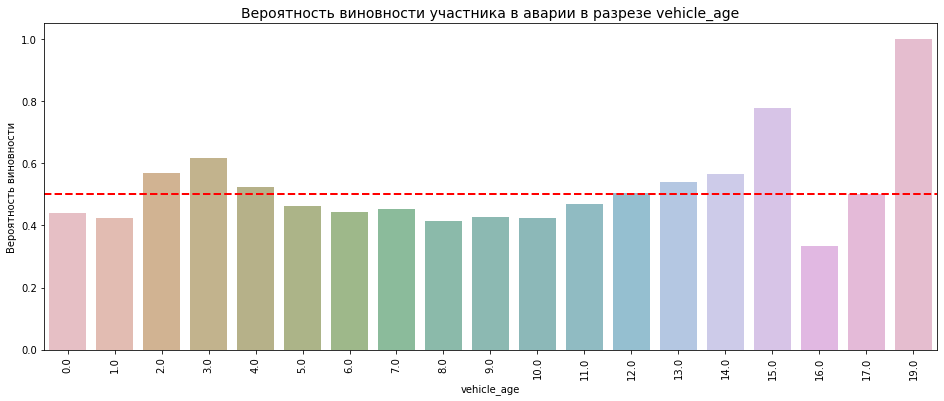

In [66]:
# Выведем график по возрасту автомобилей
ratio_at_fault(data=df, x='vehicle_age', y='at_fault')

Есть рост риска в интервале 2 - 3 лет, а также плавный рост с возрастом после 10 лет.

#### Состояние участников

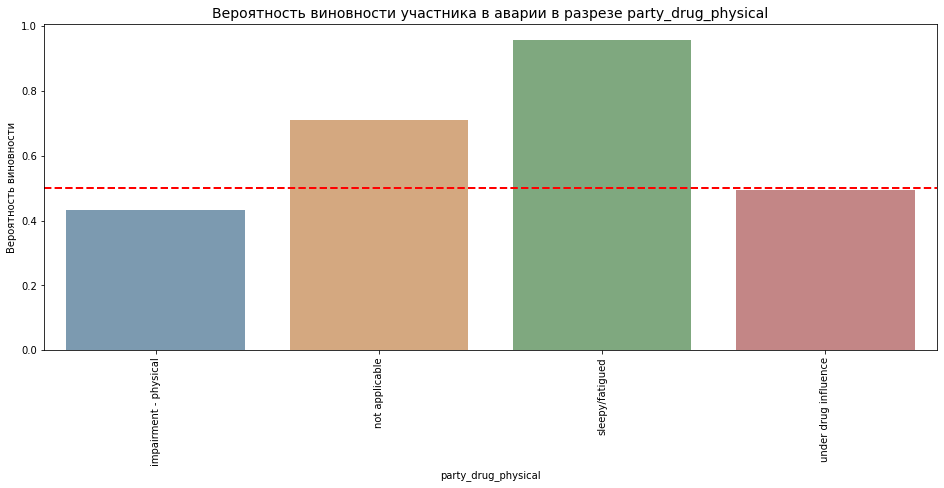

In [67]:
# Выведем график с состоянием участника аварий
ratio_at_fault(data=df, x='party_drug_physical', y='at_fault')

Усталость - максимальные риски виновности, также значительные риски у группы чье состояние не фиксировалось.

In [68]:
# Выведем информацию по выборке
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54945 entries, 0 to 56247
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  54945 non-null  object 
 1   distance              54945 non-null  float64
 2   direction             54945 non-null  object 
 3   intersection          54945 non-null  float64
 4   weather_1             54945 non-null  object 
 5   location_type         54945 non-null  object 
 6   road_surface          54945 non-null  object 
 7   road_condition_1      54945 non-null  object 
 8   lighting              54945 non-null  object 
 9   control_device        54945 non-null  object 
 10  collision_month       54945 non-null  int64  
 11  collision_dow         54945 non-null  int64  
 12  collision_hour        54945 non-null  float64
 13  vehicle_type          54945 non-null  object 
 14  vehicle_transmission  54945 non-null  object 
 15  vehicle_age        

In [69]:
df.columns

Index(['county_city_location', 'distance', 'direction', 'intersection',
       'weather_1', 'location_type', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'collision_month', 'collision_dow',
       'collision_hour', 'vehicle_type', 'vehicle_transmission', 'vehicle_age',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use', 'at_fault'],
      dtype='object')

In [70]:
# Поменяем тип данных на категориальный там где это необходимо
columns = ['county_city_location', 'direction', 'intersection', 'weather_1', 'location_type', 'road_surface',
       'road_condition_1', 'lighting', 'control_device', 'vehicle_type',
       'vehicle_transmission', 'party_sobriety', 'party_drug_physical', 'cellphone_in_use', 'collision_hour', 'vehicle_age'
           , 'collision_dow', 'collision_month']
for col in columns:
    df[col] = df[col].astype('category')

In [71]:
# Поменяем тип данных на int64 там где это необходимо
columns = ['distance', 'insurance_premium']
for col in columns:
    df[col] = df[col].astype('int64')

In [72]:
# Выведем информацию по выборке
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54945 entries, 0 to 56247
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   county_city_location  54945 non-null  category
 1   distance              54945 non-null  int64   
 2   direction             54945 non-null  category
 3   intersection          54945 non-null  category
 4   weather_1             54945 non-null  category
 5   location_type         54945 non-null  category
 6   road_surface          54945 non-null  category
 7   road_condition_1      54945 non-null  category
 8   lighting              54945 non-null  category
 9   control_device        54945 non-null  category
 10  collision_month       54945 non-null  category
 11  collision_dow         54945 non-null  category
 12  collision_hour        54945 non-null  category
 13  vehicle_type          54945 non-null  category
 14  vehicle_transmission  54945 non-null  category
 15  ve

## Создайте модель для оценки водительского риска

### Подготовка данных

In [73]:
# Разделение данных
X = df.drop('at_fault', axis=1)
y = df['at_fault']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Определение числовых и категориальных столбцов
#num_cols = ['distance', 'insurance_premium', 'collision_hour', 'vehicle_age', 'collision_month', 'collision_dow']
#te_cols = ['county_city_location', 'direction', 'intersection', 'weather_1', 'location_type', 'road_surface',
#       'road_condition_1', 'lighting', 'control_device', 'vehicle_type',
#       'vehicle_transmission', 'party_sobriety', 'party_drug_physical', 'cellphone_in_use']
#or_cols = ['collision_hour', 'vehicle_age', 'collision_month', 'collision_dow']

Данные разделены. Реализуем пайплан с тремя моделями 'LogisticRegression', 'RandomForestClassifier' и 'CatBoostClassifier' и перебором их гиперпараметров. 
<br>
Исходя из поставленной заказчиком задачи, нам, при оценке вероятности виновности в аварии, важно не пропустить потенциальных виновников, поэтому мы делаем акцент на Recall. В то же время, у нас есть определенная стоимость ложных срабатываний (это отказ от поездки, изменение маршрута и т.д.) что означает важность метрики Precision. 
<br>
Таким образом, сопоставляя потенциальную стоимость ошибки модели, приоритет все же будет иметь Recall, но Precision то же не должен падать ниже определенного уровня при выборе границы классификации. И в дальнейшем, мы предоставим заказчику данный инструмент (порог классификации) для обоснованной настройки модели с учетом его экономических расчетов.

### Pipeline с перебором гиперпараметров

In [74]:
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module='sklearn.preprocessing._encoders'
)

In [75]:
# Определение колонок для разных типов кодирования
ohe_cols = [
    'direction', 'intersection', 'weather_1', 'location_type',
    'road_surface', 'road_condition_1', 'lighting', 'control_device',
    'vehicle_type', 'vehicle_transmission', 'party_sobriety',
    'party_drug_physical', 'cellphone_in_use','county_city_location'
]
ord_cols = ['distance', 'collision_month', 'collision_dow', 'collision_hour']

num_cols = ['vehicle_age', 'insurance_premium']

cat_cols = ohe_cols + ord_cols

# Создание пайплайна для LogisticRegression
log_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
        ('scaler', StandardScaler(), num_cols)
    ]
)

# Создание пайплайна для RandomForest и CatBoost
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ohe_cols),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_cols),
        ('scaler', StandardScaler(), num_cols)
    ]
)

# Параметры для поиска
param_distributions = {
    'LogisticRegression': {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [50, 100, 150],
        'classifier__max_depth': [ 5, 10],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'CatBoostClassifier': {
        'classifier__iterations': [200, 300, 400],
        'classifier__depth': [4, 6, 8],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
}

# Создание и обучение моделей
models = {
    'LogisticRegression': Pipeline(
        steps=[
            ('preprocessor', log_preprocessor),
            ('classifier', LogisticRegression())
        ]
    ),
    'RandomForestClassifier': Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(random_state=42))
        ]
    ),
    'CatBoostClassifier': Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', CatBoostClassifier(verbose=0))
        ]
    )
}

results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    start_time = time.time()
    
    # Настройка поиска гиперпараметров
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[model_name],
        scoring='recall',
        n_iter=10,  
        cv=5,      
        verbose=1,
        n_jobs=-1,
        random_state=42,
        error_score='raise'  
    )
    
    try:
        search.fit(X_train, y_train)
    except Exception as e:
        print(f"Ошибка при обучении {model_name}: {e}")
        continue
    
    # Замер времени обучения
    train_time = time.time() - start_time
    
    # Замер времени предсказания
    start_time = time.time()
    y_pred = search.predict(X_train)
    predict_time = time.time() - start_time
    
    # Сохранение результатов
    results[model_name] = {
        'best_params': search.best_params_,
        'train_time': train_time,
        'predict_time': predict_time,
        'recall': recall_score(y_train, y_pred)
    }

# Вывод результатов в таблицу
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

# Выбор лучшей модели по recall
best_model_name = results_df['recall'].idxmax()
best_model = models[best_model_name]
print(f"\nBest Model: {best_model}")

Training LogisticRegression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training RandomForestClassifier...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training CatBoostClassifier...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
                                                                                                               best_params  \
LogisticRegression                                        {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2'}   
RandomForestClassifier  {'classifier__n_estimators': 50, 'classifier__min_samples_split': 10, 'classifier__max_depth': 10}   
CatBoostClassifier              {'classifier__learning_rate': 0.01, 'classifier__iterations': 200, 'classifier__depth': 6}   

                        train_time  predict_time    recall  
LogisticRegression       31.109060      0.210143  0.570761  
RandomForestClassifier  103.319826      0.393953  0.553233  
CatBoostClassifier      282.738261      0.275582  0.580055  

Best Model: Pipeline(steps=[('preprocessor',
                 

Лучшей моделью оказалась CatBoostClassifier с метрикой recall 0.58. Уровень качества не высокий, но ожидаемый учитывая низкие коэффициенты корреляции с целевым признаком. Попробуем далее поднять порог классификации.

### Оценка лучшей модели на тестовой выборке


In [76]:
# Получаем лучшую модель из поиска
best_pipeline = search.best_estimator_

# Разделяем компоненты пайплайна
final_estimator = best_pipeline.named_steps['classifier']
preprocessor = best_pipeline.named_steps['preprocessor']

# Применяем препроцессор к тестовым данным
X_test_transformed = preprocessor.transform(X_test)

# Делаем предсказания на тестовой выборке
y_pred = final_estimator.predict(X_test_transformed)

# Оценка качества модели
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Recall: 0.5877509750108334

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.74      0.69      6814
           1       0.70      0.59      0.64      6923

    accuracy                           0.66     13737
   macro avg       0.67      0.67      0.66     13737
weighted avg       0.67      0.66      0.66     13737



recall 0.59, посмотрим на матрицу ошибок и ROC-кривую. 

Confusion Matrix:


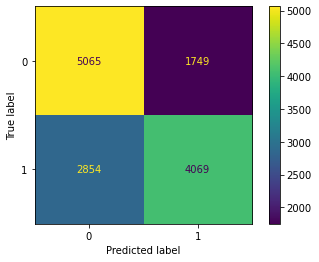

In [77]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

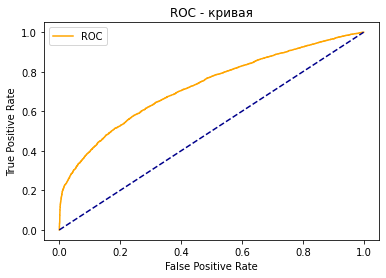

In [78]:
# Выведем ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, best_pipeline.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - кривая')
plt.legend()
plt.show()

In [79]:
print('Recall', recall_score(y_test, final_estimator.predict_proba(X_test_transformed)[:, 1]>=0.4))
print("\nClassification Report:\n", classification_report(y_test, final_estimator.predict_proba(X_test_transformed)[:, 1]>=0.4))

Recall 0.7850642784919832

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.49      0.57      6814
           1       0.61      0.79      0.69      6923

    accuracy                           0.64     13737
   macro avg       0.65      0.64      0.63     13737
weighted avg       0.65      0.64      0.63     13737



При снижении порога классификации до 0.4 Recall возрастает до 0.79, при Precision остающемся на приемлемом уровне (0.61). То есть модель позволяет выявлять 79% виновников, что можно считать удовлетворительным результатом с учетом имеющихся данных.

## Проведите анализ важности факторов ДТП

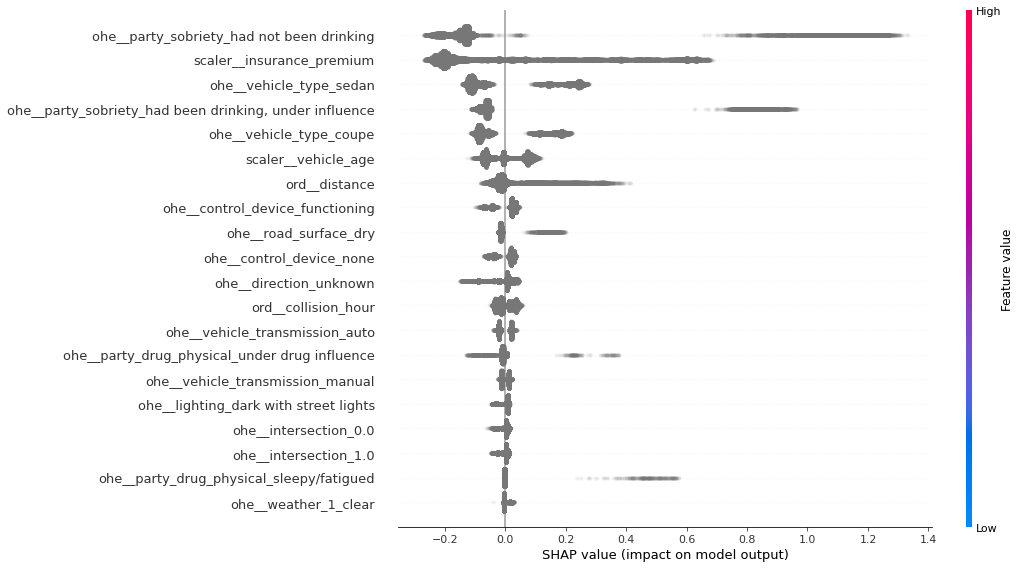

In [80]:
# Выведем график для анализа важности признаков

# Преобразуем тренировочные данные
X_train_transformed = preprocessor.transform(X_train)

# Создаем explainer в зависимости от типа лучшей модели
if isinstance(final_estimator, RandomForestClassifier):
    explainer = shap.TreeExplainer(final_estimator)
elif isinstance(final_estimator, CatBoostClassifier):
    explainer = shap.TreeExplainer(final_estimator)
elif isinstance(final_estimator, LogisticRegression):
    explainer = shap.LinearExplainer(final_estimator)
else:
    raise ValueError("Неподдерживаемый тип модели")

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_train_transformed)

# Получаем имена признаков после преобразования
feature_names = preprocessor.get_feature_names_out()
# Отображаем сводный график
shap.summary_plot(
    shap_values, 
    X_train_transformed, 
    feature_names=feature_names,
    plot_size=(15, 8),  
    alpha=0.1, 
    show=False         
)

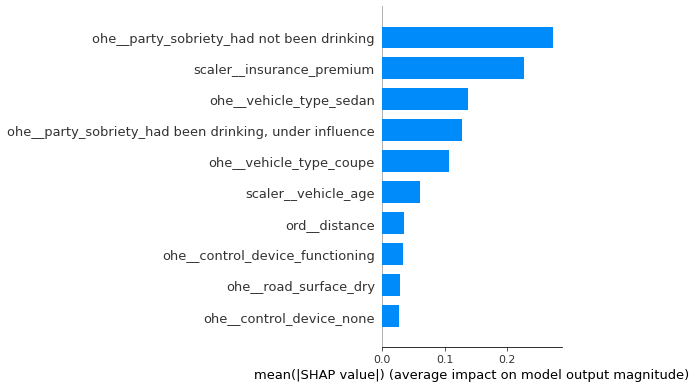

In [81]:
plt.figure(figsize=(14, 8))
shap.summary_plot(
    shap_values, 
    X_train_transformed, 
    feature_names=feature_names,
    plot_type='bar',
    max_display=10,  # Показать топ-10 признаков
    show=False
)

Самый важный признак трезвость участника (PARTY_SOBRIETY Had Not Been Drinking (Не пил)), затем стоимость страховки, трезвость (Had Been Drinking, Under Influence (Был пьян, под влиянием)) и тип кузова автомобиля.

## Выводы

Нам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
<br>
Для выполнения поставленной задачи было осуществлено подключение к базе данных. Проверено наличие необходимых нам таблиц среди имеющихся в БД. В работе нам были нужны таблицы collisions, parties и vehicles.
<br>
К первому совещанию нашей рабочей группы мы сформировали подходящие аналитические задачи и часть из них поручили решить коллегам. 
<br>
Для себя оставили три вопроса:
<br>
1. Проанализировать процент аварий по тяжести повреждений автомобилей в разрезе состояния дорожного покрытия;
<br>
2. Проанализировать процент аварий при разной освещенности в разрезе состояния дорожной обстановки;
<br>
3. Проанализировать процент аварий по возрасту автомобилей на различных дорожных участках



Эти задачи были проанализированы и сделаны соответствующие выводы.
Затем мы выгрузили с помощью SQL-запроса из БД данные для модели, отфильтровав их согласно рекомендаций заказчика.
Максимально корректно заполнили пропуски, незначительное количество строк удалили. Провели общий корреляционнный анализ, по результатам которого приняли решение не использовать признаки party_count, pcf_violation_category, motor_vehicle_involved_with, type_of_collision, primary_collision_factor и collision_damage. Так как они формируются по факту аварии, поэтому их нельзя было использовать в модели. По оставшимся признакам выделили наиболее песпективные и провели по ним корреляционный анализ с выводом графического материала.
<br>
Далее мы разделили данные на тренировочную и тестовую выборки. Затем реализовали пайплайн с тремя моделями 'LogisticRegression', 'RandomForestClassifier' и 'CatBoostClassifier' и перебором их гиперпараметров. Исходя из поставленной заказчиком задачи, нам необходимо для оценки качества моделей использовать recall.
<br>
По результатам перебора были подобраны гиперпараметры для каждой из моделей. Наилучший результат продемонстрировала модель CatBoostClassifier. Которая на тестовых данных показала recall 0.58. Исходя из поставленной заказчиком задачи, было принято решение понизить порог классификации, для того чтобы увеличить охват потенциальных виновников аварий.
<br>
После снижения порога классификации до 0.38 Recall вырос до 0.77, при Precision остающемся на приемлемом уровне (0.6). Что в данном случае, можно считать удовлетворительным результатом. Таким образом модель позволяет выявлять 78% потенциальных виновников ДТП.
<br>
Далее был произведен анализ фажности факторов, по результатам которого было отмечено, что самый важный признак это трезвость участника (PARTY_SOBRIETY Had Not Been Drinking (Не пил)), затем стоимость страховки, трезвость (Had Been Drinking, Under Influence (Был пьян, под влиянием)) и тип кузова автомобиля. Это означает ключевой фактор который можно выделить по результатам исследования - трезвость (состояние) водителя. 
<br>
<br>
Также необходимо напомнить что только факт нарушения правил при инциденте позволяет официально признать участника виновным. Т.е. 100% соблюдение правил дает 100% гарантию невиновности в случае инцидента, и наоборот. Поэтому большенство из представленных признаков в исследовании являются по своей сути следствием полноты соблюдения правил.
<br>
<br>
Можно ли воздействовать на признак "трезвость" с целью снижения риска виновности? Да, это возможно в случае реализации системы, когда после выбора маршрута водителю предоставляется информация о доли риска быть инициатором аварии при различном уровне трезвости согласно классификации: 

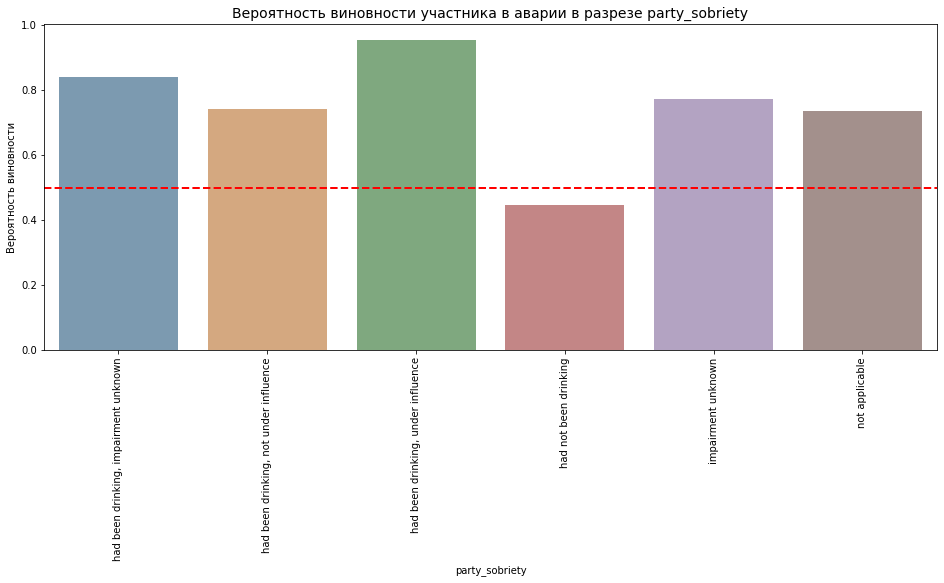

In [82]:
# Что-то подобное
ratio_at_fault(data=df, x='party_sobriety', y='at_fault')